## 0. Set up

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

# import base packages into the namespace for this program
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import subprocess
import seaborn as sns
from pandas_profiling import ProfileReport

#SKlearn
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, classification_report
from datetime import datetime

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Machine Learning Final Project/mushrooms.csv')
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 1. EDA

In [6]:
data.shape

(8124, 23)

In [7]:
# Check for Missing Value
data.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [8]:
# Missing Value heatmap
plt.figure(figsize=(10,6))
sns.heatmap(data.isnull())

In [9]:
#Basic stats descriptive statistics
data.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [11]:
total_miss = data.isnull().sum().sort_values(ascending=False)
miss = round(data.isnull().sum()/data.isnull().count()*100,1).sort_values(ascending=False)
missing_data = pd.concat([total_miss, miss], axis=1, keys=['Missing data', '%'])
missing_data = missing_data[missing_data['Missing data']>0]
missing_data

,Missing data,%


In [12]:
# missing_data = missing_data[missing_data['Missing data']>0]

# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_theme(style="whitegrid")
# ax = sns.barplot(x=missing_data.index, y="Missing data", data=missing_data)

In [13]:
# Density Plot
import plotly.express as px

columns = ['class', 'habitat']

fig = px.density_contour(data[columns], 
                         x=data['class'], 
                         y=data['habitat'], 
                         marginal_x="histogram", 
                         marginal_y="histogram")

fig.update_layout(
    title="Density plot",
    xaxis_title="Class",
    yaxis_title="Habitat")

fig.show()

### 1.1 Class (Target Variable)

In [14]:
sns.histplot(data=data, x="class") #data is pretty evenly divided between poisonous and edible classes

In [15]:
# Update target variable to poisonous
data.loc[data['class']=='p', 'class'] = 1
data.loc[data['class']=='e', 'class'] = 0
data=data.rename(columns={'class':'poisonous'})

### 1.2 Cap-shape
bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s

Consider consolidate the categories

In [16]:
# Only 4 observations for cap-shape = c
# Only 32 observations for cap-shape = s

data['cap-shape'].value_counts()

x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64

In [17]:
sns.histplot(data=data, x="cap-shape")

In [18]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=data, x_vars=['cap-shape'], y_vars='poisonous', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))

In [19]:
is_poisonous = data[data['poisonous'] ==1]
not_poisonous = data[data['poisonous'] ==0]

In [20]:
sns.histplot(data = is_poisonous, x = 'cap-shape')
sns.histplot(data = not_poisonous, x = 'cap-shape', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [21]:
df_p = data[data['poisonous']==1]

In [22]:
df_p['cap-shape'].value_counts().sort_index().plot.pie(title = "Poisonous class cap-shape components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.3 Cap-surface
fibrous=f,grooves=g,scaly=y,smooth=s

In [23]:
# Only 4 observations for cap-surface = g
data['cap-surface'].value_counts()

y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64

In [24]:
sns.histplot(data=data, x="cap-surface")

In [25]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=data, x_vars=['cap-surface'], y_vars='poisonous', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))

In [26]:
sns.histplot(data = is_poisonous, x = 'cap-surface')
sns.histplot(data = not_poisonous, x = 'cap-surface', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [27]:
df_p['cap-surface'].value_counts().sort_index().plot.pie(title = "Poisonous class cap-surface components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.4 Cap-color
brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

Consider consolidate the categories

In [28]:
# minority colors
data['cap-color'].value_counts()

n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64

In [29]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=data, x_vars=['cap-color'], y_vars='poisonous', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))

In [30]:
sns.histplot(data = is_poisonous, x = 'cap-color')
sns.histplot(data = not_poisonous, x = 'cap-color', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [31]:
df_p['cap-color'].value_counts().sort_index().plot.pie(title = "Poisonous class cap-color components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.5 Bruises

In [32]:
print(data['bruises'].value_counts(),'\n',data['bruises'].value_counts(normalize=True)*100)

f    4748
t    3376
Name: bruises, dtype: int64 
 f    58.444116
t    41.555884
Name: bruises, dtype: float64


In [33]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=data, x_vars=['bruises'], y_vars='poisonous', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))

In [34]:
sns.histplot(data = is_poisonous, x = 'bruises')
sns.histplot(data = not_poisonous, x = 'bruises', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [35]:
df_p['bruises'].value_counts().sort_index().plot.pie(title = "Poisonous class bruises components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.6 Odor
almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

Consider consolidate the categories

In [36]:
print(data['odor'].value_counts(),'\n',data['odor'].value_counts(normalize=True)*100)

n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64 
 n    43.426883
f    26.587888
y     7.090103
s     7.090103
a     4.923683
l     4.923683
p     3.151157
c     2.363368
m     0.443131
Name: odor, dtype: float64


In [37]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=data, x_vars=['odor'], y_vars='poisonous', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))

In [38]:
sns.histplot(data = is_poisonous, x = 'odor')
sns.histplot(data = not_poisonous, x = 'odor', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [ ]:
df_p['odor'].value_counts().sort_index().plot.pie(title = "Poisonous class odor components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.7 Gill-attachment
attached=a, descending=d, free=f, notched=n

In [ ]:
# Only 2 categories present in data
print(data['gill-attachment'].value_counts(),'\n',data['gill-attachment'].value_counts(normalize=True)*100)

f    7914
a     210
Name: gill-attachment, dtype: int64 
 f    97.415066
a     2.584934
Name: gill-attachment, dtype: float64


In [ ]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=data, x_vars=['gill-attachment'], y_vars='poisonous', size=5)
g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
g.set(ylim=(0, 1))

In [ ]:
df_p['gill-attachment'].value_counts().sort_index().plot.pie(title = "Poisonous class gill-attachment components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.8 Gill-spacing

In [ ]:
data['gill-spacing'].isna().sum()

0

In [ ]:
data['gill-spacing'].value_counts(normalize=True)*100

c    83.85032
w    16.14968
Name: gill-spacing, dtype: float64

In [ ]:
g = sns.pointplot(x='gill-spacing', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
sns.histplot(data = is_poisonous, x = 'gill-spacing')
sns.histplot(data = not_poisonous, x = 'gill-spacing', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [ ]:
df_p['gill-spacing'].value_counts().sort_index().plot.pie(title = "Poisonous class gill-spacing components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.9 Gill-size

In [ ]:
data['gill-size'].isna().sum()

0

In [ ]:
data['gill-size'].value_counts(normalize=True)*100

b    69.079271
n    30.920729
Name: gill-size, dtype: float64

In [ ]:
g = sns.pointplot(x='gill-size', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
sns.histplot(data = is_poisonous, x = 'gill-size')
sns.histplot(data = not_poisonous, x = 'gill-size', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [ ]:
df_p['gill-spacing'].value_counts().sort_index().plot.pie(title = "Poisonous class gill-size components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.10 Gill-color

In [ ]:
data['gill-color'].isna().sum()

0

In [ ]:
data['gill-color'].value_counts(normalize=True)*100

b    21.270310
p    18.365337
w    14.795667
n    12.900049
g     9.256524
h     9.010340
u     6.056130
k     5.022157
e     1.181684
y     1.058592
o     0.787789
r     0.295421
Name: gill-color, dtype: float64

In [ ]:
g = sns.pointplot(x='gill-color', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
sns.histplot(data = is_poisonous, x = 'gill-color')
sns.histplot(data = not_poisonous, x = 'gill-color', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [ ]:
df_p['gill-color'].value_counts().sort_index().plot.pie(title = "Poisonous class gill-color components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.11 Stalk-shape

In [ ]:
data['stalk-shape'].isna().sum()

0

In [ ]:
data['stalk-shape'].value_counts(normalize=True)*100

t    56.720827
e    43.279173
Name: stalk-shape, dtype: float64

In [ ]:
g = sns.pointplot(x='stalk-shape', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
df_p['stalk-shape'].value_counts().sort_index().plot.pie(title = "Poisonous class stalk-shape components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.12 Stalk-root

In [ ]:
data['stalk-root'].isna().sum()

0

In [ ]:
data['stalk-root'].value_counts(normalize=True)*100

b    46.479567
?    30.526834
e    13.786312
c     6.843919
r     2.363368
Name: stalk-root, dtype: float64

In [ ]:
g = sns.pointplot(x='stalk-root', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
df_p['stalk-root'].value_counts().sort_index().plot.pie(title = "Poisonous class stalk-root components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.13 Stalk-surface-above-ring

In [ ]:
data['stalk-surface-above-ring'].isna().sum()

0

In [ ]:
data['stalk-surface-above-ring'].value_counts(normalize=True)*100

s    63.712457
k    29.197440
f     6.794682
y     0.295421
Name: stalk-surface-above-ring, dtype: float64

In [ ]:
g = sns.pointplot(x='stalk-surface-above-ring', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
df_p['stalk-surface-above-ring'].value_counts().sort_index().plot.pie(title = "Poisonous class stalk-surface-above-ring components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.14 Stalk-surface-below-ring

In [ ]:
data['stalk-surface-above-ring'].isna().sum()

0

In [ ]:
data['stalk-surface-below-ring'].value_counts(normalize=True)*100

s    60.758247
k    28.360414
f     7.385524
y     3.495815
Name: stalk-surface-below-ring, dtype: float64

In [ ]:
g = sns.pointplot(x='stalk-surface-below-ring', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
df_p['stalk-surface-below-ring'].value_counts().sort_index().plot.pie(title = "Poisonous class stalk-surface-below-ring components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.15 Stalk-color-above-ring

In [ ]:
data['stalk-color-above-ring'].isna().sum()

0

In [ ]:
data['stalk-color-above-ring'].value_counts(normalize=True)*100

w    54.948301
p    23.042836
g     7.090103
n     5.514525
b     5.317578
o     2.363368
e     1.181684
c     0.443131
y     0.098474
Name: stalk-color-above-ring, dtype: float64

In [ ]:
g = sns.pointplot(x='stalk-color-above-ring', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
sns.histplot(data = is_poisonous, x = 'stalk-color-above-ring')
sns.histplot(data = not_poisonous, x = 'stalk-color-above-ring', color = "orange")
plt.legend(labels=["is_poisonous, not_poisonous"])

In [ ]:
df_p['stalk-surface-above-ring'].value_counts().sort_index().plot.pie(title = "Poisonous class stalk-surface-below-ring components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.16 Stalk-color-below-ring

In [ ]:
data['stalk-color-below-ring'].isna().sum()

0

In [ ]:
data['stalk-color-below-ring'].value_counts(normalize=True)*100

w    53.963565
p    23.042836
g     7.090103
n     6.302314
b     5.317578
o     2.363368
e     1.181684
c     0.443131
y     0.295421
Name: stalk-color-below-ring, dtype: float64

In [ ]:
g = sns.pointplot(x='stalk-color-below-ring', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
df_p['stalk-surface-below-ring'].value_counts().sort_index().plot.pie(title = "Poisonous class stalk-surface-below-ring components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.17 Veil-type (Dropped)

In [ ]:
data['veil-type'].isna().sum()

0

In [ ]:
data['veil-type'].value_counts(normalize=True)*100

p    100.0
Name: veil-type, dtype: float64

In [ ]:
g = sns.pointplot(x='veil-type', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1)) #LOL

[(0.0, 1.0)]

In [ ]:
data = data.drop('veil-type',1)

In [ ]:
df_p['veil-type'].value_counts().sort_index().plot.pie(title = "Poisonous class veil-type components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.18 Veil-color

In [ ]:
data['veil-color'].isna().sum()

0

In [ ]:
data['veil-color'].value_counts(normalize=True)*100

w    97.538159
n     1.181684
o     1.181684
y     0.098474
Name: veil-color, dtype: float64

In [ ]:
g = sns.pointplot(x='veil-color', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1)) 

[(0.0, 1.0)]

In [ ]:
df_p['veil-color'].value_counts().sort_index().plot.pie(title = "Poisonous class veil-color components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.19 Ring-number

In [ ]:
data['ring-number'].isna().sum()

0

In [ ]:
data['ring-number'].value_counts(normalize=True)*100

o    92.171344
t     7.385524
n     0.443131
Name: ring-number, dtype: float64

In [ ]:
g = sns.pointplot(x='ring-number', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1)) 

[(0.0, 1.0)]

In [ ]:
df_p['ring-number'].value_counts().sort_index().plot.pie(title = "Poisonous class ring-number components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.20 Ring-type


*   Imbalance data: ring-type = 'f' and 'n' have insufficient amount of data points
*   class "l" and "n" have 100% posionous mushrooms 

*   class 'f' has no posionous mushroom







In [ ]:
print(data['ring-type'].value_counts(),'\n', data['ring-type'].value_counts(normalize=True)*100)

p    3968
e    2776
l    1296
f      48
n      36
Name: ring-type, dtype: int64 
 p    48.842935
e    34.170359
l    15.952733
f     0.590842
n     0.443131
Name: ring-type, dtype: float64


In [ ]:
g = sns.pointplot(x='ring-type', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
sns.histplot(data = is_poisonous, x = 'ring-type')
sns.histplot(data = not_poisonous, x = 'ring-type', color = "orange")
plt.legend(labels=["is_poisonous", "not_poisonous"])

In [ ]:
# Ring Type
# poisonous class ring_type components
plt.figure(figsize=(6,6))
df_p = data[data['poisonous']==1]
sns.countplot(df_p['ring-type'])
plt.xlabel('ring_type')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

In [ ]:
df_p['ring-type'].value_counts().sort_index().plot.pie(title = "Poisonous class ring_type components",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.21 Spore-print-color


*   Imbalance class: r, u, o , y, b has insufficent amount of data points
*   Spore-print-color = ['u','o','y','b'] has no posionous mushrooms



In [ ]:
print(data['spore-print-color'].value_counts(),'\n', data['spore-print-color'].value_counts(normalize=True)*100)

w    2388
n    1968
k    1872
h    1632
r      72
u      48
o      48
y      48
b      48
Name: spore-print-color, dtype: int64 
 w    29.394387
n    24.224520
k    23.042836
h    20.088626
r     0.886263
u     0.590842
o     0.590842
y     0.590842
b     0.590842
Name: spore-print-color, dtype: float64


In [ ]:
g = sns.pointplot(x='spore-print-color', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
sns.histplot(data = is_poisonous, x = 'spore-print-color')
sns.histplot(data = not_poisonous, x = 'spore-print-color', color = "orange")
plt.legend(labels=["is_poisonous", "not_poisonous"])

In [ ]:
# spore-print-color  
plt.figure(figsize=(6,6))
sns.countplot(df_p['spore-print-color'])
plt.xlabel('spore-print-color')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

In [ ]:
df_p['spore-print-color'].value_counts().sort_index().plot.pie(title = "Poisonous class spore-print-color",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.22 Population


*   population "n" and "a" have no posionous mushrooms
*   population "v" has high proportion of posionous mushrooms



In [ ]:
print(data['population'].value_counts(),'\n', data['population'].value_counts(normalize=True)*100)

v    4040
y    1712
s    1248
n     400
a     384
c     340
Name: population, dtype: int64 
 v    49.729197
y    21.073363
s    15.361891
n     4.923683
a     4.726736
c     4.185130
Name: population, dtype: float64


In [ ]:
g = sns.pointplot(x='population', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
sns.histplot(data = is_poisonous, x = 'population')
sns.histplot(data = not_poisonous, x = 'population', color = "orange")
plt.legend(labels=["is_poisonous", "not_poisonous"])

In [ ]:
# population
plt.figure(figsize=(6,6))
sns.countplot(df_p['population'])
plt.xlabel('Population')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

In [ ]:
df_p['population'].value_counts().sort_index().plot.pie(title = "Poisonous class population",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

### 1.23 Habitat


*   habitat = 'w' has no posionous mushrooms in this dataset. However, 'w' is an imbalance class


*   "g""d" "m" are habitats categories that have high percentage of not posionous mushrooms
*   "u","p","i" are habitats where greater proportion mushrooms are  posionous/





In [ ]:
print(data['habitat'].value_counts(),'\n', data['habitat'].value_counts(normalize=True)*100)

d    3148
g    2148
p    1144
l     832
u     368
m     292
w     192
Name: habitat, dtype: int64 
 d    38.749385
g    26.440177
p    14.081733
l    10.241260
u     4.529788
m     3.594289
w     2.363368
Name: habitat, dtype: float64


In [ ]:
g = sns.pointplot(x='habitat', y='poisonous', data=data, showmeans=True)
g.set(ylim=(0, 1))

[(0.0, 1.0)]

In [ ]:
sns.histplot(data = is_poisonous, x = 'habitat')
sns.histplot(data = not_poisonous, x = 'habitat', color = "orange")
plt.legend(labels=["is_poisonous", "not_poisonous"])

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(df_p['habitat'])
plt.xlabel('habitat')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

In [ ]:
df_p['habitat'].value_counts().sort_index().plot.pie(title = "Poisonous class habitat",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))

## 2. Baseline Model

In [ ]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

In [1]:
X

NameError: ignored

In [ ]:
X,y = data.drop('poisonous',1), data['poisonous']
X = pd.get_dummies(X, prefix = 'is')
y=y.astype('int')

In [ ]:
train_X,test_X,train_y,test_y = train_test_split(X,y,train_size=0.8,test_size=0.2)

In [ ]:
print(train_X.shape)
print(test_X.shape)

(6499, 116)
(1625, 116)


In [ ]:
def dmp_first_classifier(model):
    classifier = model()
    classifier.fit(train_X, train_y)
    print(classifier.score(test_X, test_y))
    return classifier

In [ ]:
#define functions for comparing RMSE

from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import cross_val_score

def compare_RMSE(model,train_X,train_y,test_X,test_y):
    
    # test
    test_rmse = mean_squared_error(test_y, model.predict(test_X), squared=False)
    print(f"Test set RMSE:", test_rmse)

    # cv
    MSE_CV_scores = - cross_val_score(model, train_X, train_y, cv=10, 
                                      scoring='neg_mean_squared_error', 
                                      n_jobs=-1) 
    RMSE_CV = (MSE_CV_scores.mean())**(1/2)
    print(f"CV RMSE:", RMSE_CV)

    # train
    RMSE_train = (mean_squared_error(train_y, model.predict(train_X)))**(1/2)
    print(f"Training set RMSE:",RMSE_train)

### 2.1 Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(train_X,train_y)
y_pred_log_reg = log_reg.predict(test_X)
acc_log_reg = round(log_reg.score(test_X, test_y) * 100, 2)
print (str(acc_log_reg) + ' percent')

100.0 percent


In [ ]:
precision_log_reg = metrics.precision_score(test_y, y_pred_log_reg)
recall_log_reg = metrics.recall_score(test_y, y_pred_log_reg)
f1_log_reg = metrics.f1_score(test_y, y_pred_log_reg)

print("Precision:",precision_log_reg)
print("Recall:",recall_log_reg)
print("F1:",f1_log_reg)

Precision: 1.0
Recall: 1.0
F1: 1.0


In [ ]:
# compare_RMSE(log_reg,train_X, train_y,test_X,test_y)

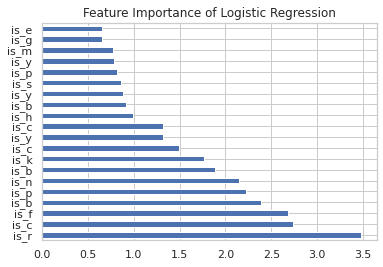

In [ ]:
# Feature importance for logistic regression (Coefficients as Feature Importance)
importance = log_reg.coef_[0]
feat_importances = pd.Series(importance, index = train_X.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance of Logistic Regression')


### 2.2 SGDC

In [ ]:
SGDC = SGDClassifier()
SGDC.fit(train_X,train_y)
y_pred_SGDC = SGDC.predict(test_X)
acc_SGDC = round(SGDC.score(test_X, test_y) * 100, 2)
print (str(acc_SGDC) + ' percent')

100.0 percent


In [ ]:
precision_SGDC = metrics.precision_score(test_y, y_pred_SGDC)
recall_SGDC = metrics.recall_score(test_y, y_pred_SGDC)
f1_SGDC = metrics.f1_score(test_y, y_pred_SGDC)

print("Precision:",precision_SGDC)
print("Recall:",recall_SGDC)
print("F1:",f1_SGDC)

Precision: 1.0
Recall: 1.0
F1: 1.0


In [ ]:
# compare_RMSE(SGDC,train_X, train_y,test_X,test_y)

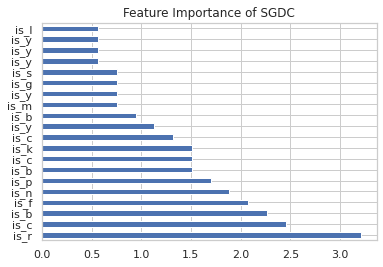

In [ ]:
# Feature importance for SGDC (Coefficients as Feature Importance)
importance = SGDC.coef_[0]
feat_importances = pd.Series(importance, index = train_X.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance of SGDC')

### 2.3 Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators = 100,min_samples_leaf=0.2,random_state=1)
rf.fit(train_X, train_y)
y_pred_rf = rf.predict(test_X)
acc_rf = round(rf.score(test_X, test_y) * 100, 2)
print (str(acc_rf) + ' percent')

87.38 percent


In [ ]:
precision_rf = metrics.precision_score(test_y, y_pred_rf)
recall_rf = metrics.recall_score(test_y, y_pred_rf)
f1_rf = metrics.f1_score(test_y, y_pred_rf)

print("Precision:",precision_rf)
print("Recall:",recall_rf)
print("F1:",f1_rf)

Precision: 0.934351145038168
Recall: 0.7906976744186046
F1: 0.8565430370888732


In [ ]:
compare_RMSE(rf,train_X, train_y,test_X,test_y)

Test set RMSE: 0.35518142709585215
CV RMSE: 0.33146014705567256
Training set RMSE: 0.3599422086933057


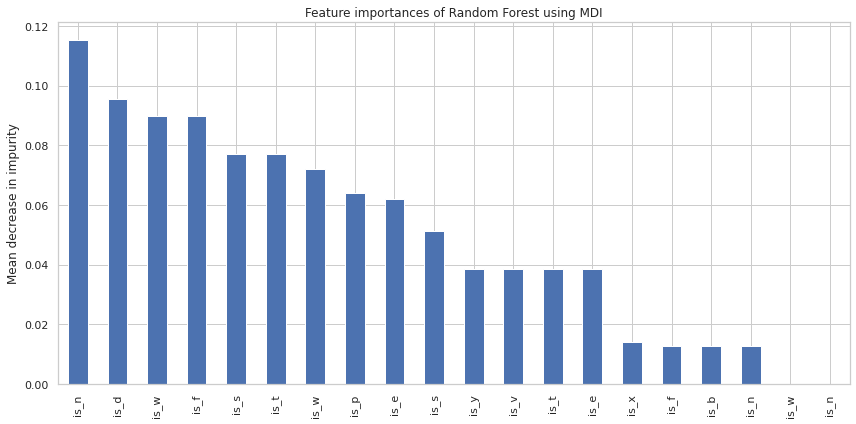

In [ ]:
# Feature importance for Random Forest
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=train_X.columns)
forest_importances = forest_importances.sort_values(ascending=False)
forest_importances = forest_importances[:20]
fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=std[:20], ax=ax,figsize=(12, 6))
ax.set_title("Feature importances of Random Forest using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 2.4 Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth=10,
                           min_samples_leaf=0.18,
                           random_state=1)

# Fit dt to the training set
dt.fit(train_X, train_y)
y_pred_dt = dt.predict(test_X)
acc_dt = round(dt.score(test_X, test_y) * 100, 2)
print (str(acc_dt) + ' percent')

89.48 percent


In [ ]:
precision_dt = metrics.precision_score(test_y, y_pred_dt)
recall_dt = metrics.recall_score(test_y, y_pred_dt)
f1_dt = metrics.f1_score(test_y, y_pred_dt)

print("Precision:",precision_dt)
print("Recall:",recall_dt)
print("F1:",f1_dt)

Precision: 1.0
Recall: 0.7790697674418605
F1: 0.8758169934640523


In [ ]:
# compare_RMSE(dt,train_X, train_y,test_X,test_y)

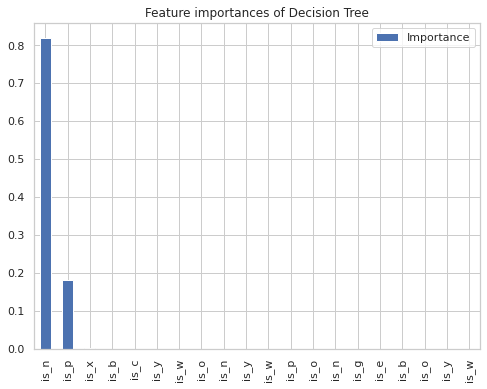

In [ ]:
# dt.feature_importances_

feat_importances = pd.DataFrame(dt.feature_importances_, index=train_X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances = feat_importances[:20]
feat_importances.plot(kind='bar', figsize=(8,6), title = "Feature importances of Decision Tree")

### 2.5 SVC

In [ ]:
svc = SVC(kernel='linear')
svc.fit(train_X,train_y)
y_pred_svc = svc.predict(test_X)
acc_svc=round(svc.score(test_X,test_y)*100,2)
print(str(acc_svc)+' percent')

100.0 percent


In [ ]:
precision_svc = metrics.precision_score(test_y, y_pred_svc)
recall_svc = metrics.recall_score(test_y, y_pred_svc)
f1_svc = metrics.f1_score(test_y, y_pred_svc)

print("Precision:",precision_svc)
print("Recall:",recall_svc)
print("F1:",f1_svc)

Precision: 1.0
Recall: 1.0
F1: 1.0


In [ ]:
compare_RMSE(svc,train_X, train_y,test_X,test_y)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('Feature Importance of SVC')
    plt.show()

In [ ]:
feature_names = train_X.columns

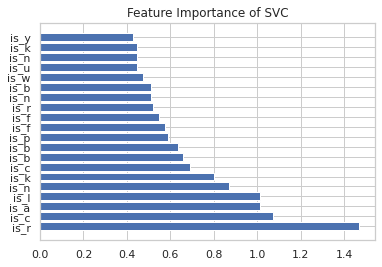

In [ ]:
f_importances(abs(svc.coef_[0]), feature_names, top=20)

In [ ]:
models = pd.DataFrame({
    'Model':['Logistic Regression','SGDClassifier','Random Forest',
             'Decision Tree','SVC'],
    
    'Accuracy':[acc_log_reg,acc_SGDC ,acc_rf,acc_dt,acc_svc],
    'F1 Score':[f1_log_reg,f1_SGDC ,f1_rf,f1_dt,f1_svc]
})

models.sort_values(by = 'F1 Score', ascending = False)

,Model,Accuracy,F1 Score
0,Logistic Regression,100.00,1.000000
1,SGDClassifier,100.00,1.000000
4,SVC,100.00,1.000000
3,Decision Tree,89.48,0.875817
2,Random Forest,87.38,0.856543


In [ ]:
roc_curve(test_y, rf.predict(test_X))

(array([0.        , 0.05052879, 1.        ]),
 array([0.        , 0.79069767, 1.        ]),
 array([2, 1, 0]))

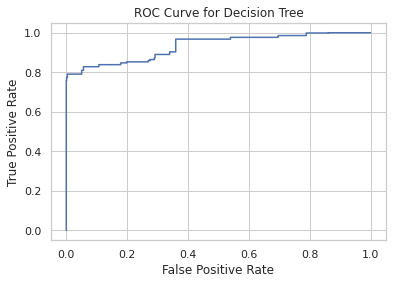

In [ ]:
y_pred_proba = rf.predict_proba(test_X)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_y,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.show()